In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

#*----------------------------------------------------------------
mpl.rcParams['font.sans-serif'] = ['SimHei']# *允许显示中文
plt.rcParams['axes.unicode_minus']=False# *允许显示坐标轴负数
#*----------------------------------------------------------------


Name		        Data Type	Meas.	    Description  
----		        ---------	-----	    -----------  
Sex		            nominal		M, F, and I (infant)  
Length		        continuous	mm          Longest shell measurement  
Diameter	        continuous	mm	        perpendicular to length  
Height		        continuous	mm	        with meat in shell  
Whole_weight	    continuous	grams	    whole abalone  
Shucked_weight	    continuous	grams	    weight of meat 肉的重量  
Viscera_weight	    continuous	grams	    gut weight (after bleeding) 放完血的重量  
Shell_weight	    continuous	grams	    after being dried 风干后的重量  
Rings		        integer		+1.5 gives the age in years     就是鲍鱼壳环的数量 代表年龄，年龄=rings + 1.5  


In [2]:
df = pd.read_csv("abalone.data",sep=",")
df.loc[df["Sex"]=="M","Sex"] = 3.0  # * 将Male类的鲍鱼设置成3
df.loc[df["Sex"]=="F","Sex"] = 2.0  # * 将Female类的鲍鱼设置成2
df.loc[df["Sex"]=="I","Sex"] = 1.0  # * 将Infant类的鲍鱼设置成1
df=df.astype(float) # * 数据类型转换
df.head(6)

,Sex,Length,Diameter,Height,Whole_weight,Shucked weight,Viscera_weight,Shell_weight,Rings
0,3.0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15.0
1,3.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7.0
2,2.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9.0
3,3.0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10.0
4,1.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7.0
5,1.0,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8.0


In [3]:
data_1 = df[["Whole_weight","Viscera_weight"]]
data_1 = data_1.sort_values(by = "Whole_weight") # *对这两列数据进行排序,排序依据为Whole_weight
data_1.head(5)

,Whole_weight,Viscera_weight
236,0.0020,0.0005
238,0.0080,0.0020
2114,0.0105,0.0065
237,0.0130,0.0030
1429,0.0140,0.0025


In [4]:
X1 = data_1["Whole_weight"] # * 构建基础数据和计算权重
length1 = len(X1)
weight_1 = np.linspace (1 , length1, length1) #* 权重
weight_1 = 1 / weight_1

In [5]:
X1 = sm.add_constant(X1)
model1 = smf.wls('Viscera_weight ~ Whole_weight',weight = weight_1,data = data_1) #* 进行加权最小二乘回归
result1 = model1.fit()
df["Whole_weight"].corr(df["Viscera_weight"],method = "pearson") #* pearson相关系数

E:\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0.9663750782730332

In [6]:
result1.summary() #* 该模型的summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:         Viscera_weight   R-squared:                       0.934
Model:                            WLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                 5.897e+04
Date:                Tue, 21 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:04:35   Log-Likelihood:                 8981.0
No. Observations:                4177   AIC:                        -1.796e+04
Df Residuals:                    4175   BIC:                        -1.795e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0016      0.001      1.842      0.066      -0.000       0.003
Whole_weight     0.2160      0.001    242.834      0.000       0.214       0.218
==============================================================================
Omnibus:                      472.625   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4495.606
Skew:                           0.050   Prob(JB):                         0.00
Kurtosis:                       8.081   Cond. No.                         3.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

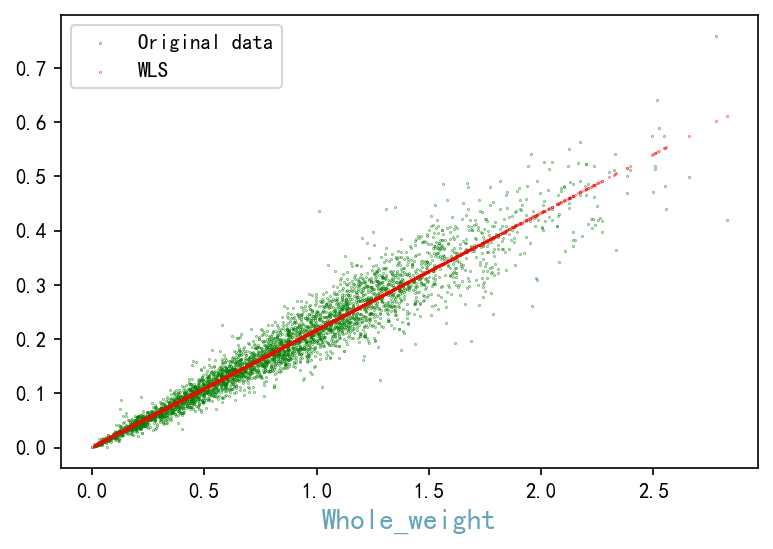

In [7]:
yfitted = result1.fittedvalues # * Viscera_weight 对 Whole_weight的WLS回归
fig, axes = plt.subplots(figsize=(6, 4), dpi=150)
axes.scatter(data_1["Whole_weight"],data_1["Viscera_weight"],c = "green",s = 0.05,alpha = 1,label = "Original data")
axes.scatter(data_1["Whole_weight"],yfitted,s= 0.05,c = "red",alpha = 1,label = "WLS")
axes.set_xlabel("Whole_weight",fontsize = 14,color = "#64a5bb")
axes.legend()
plt.savefig('images/test1.png')
plt.show()

可以看到上述summary说明，鲍鱼肉的净重和鲍鱼整体的重量存在明显线性性，但是观察可以发现，随着整体的重量的增加  
肉的净重的差异越来越大，说明存在另一个因素影响着肉的净重，其主要影响着该属性的偏差  
下面寻找整体重量和其他因素的关联,首先进行分析  

In [8]:
data_2 = df[["Sex","Rings","Whole_weight"]]

In [9]:
model2 = smf.ols('Whole_weight ~ Sex + Rings',data = data_2) #* 进行加权最小二乘回归 (此时默认权重为1)
result2 = model2.fit()
print(df["Whole_weight"].corr(df["Sex"],method = "pearson")) #* pearson相关系数
print(df["Whole_weight"].corr(df["Rings"],method = "pearson"))
result2.summary()

0.4612383803307343
0.5403896769239009


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Whole_weight   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     1257.
Date:                Tue, 21 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:04:36   Log-Likelihood:                -1965.4
No. Observations:                4177   AIC:                             3937.
Df Residuals:                    4174   BIC:                             3956.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1980      0.021     -9.272      0.000      -0.240      -0.156
Sex            0.1833      0.008     23.687      0.000       0.168       0.198
Rings          0.0656      0.002     33.035      0.000       0.062       0.070
==============================================================================
Omnibus:                      240.148   Durbin-Watson:                   0.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              316.401
Skew:                           0.540   Prob(JB):                     1.97e-69
Kurtosis:                       3.808   Cond. No.                         38.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

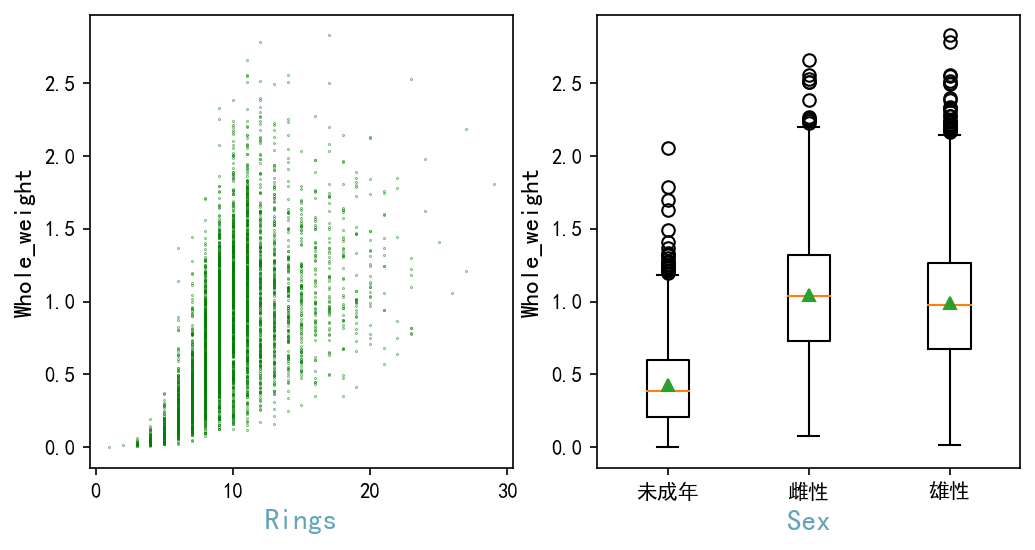

In [10]:
yfitted = result2.fittedvalues
box_sorted_data = df.sort_values(by = "Sex")
box_data = []
Levels = box_sorted_data.Sex.unique()
for Sex in Levels:
    box_data.append(box_sorted_data.loc[box_sorted_data.Sex==Sex,"Whole_weight"])
fig, axes = plt.subplots(1,2,figsize=(8, 4), dpi=150)
axes[0].scatter(data_2["Rings"],data_2["Whole_weight"],c = "green",s = 0.05,alpha = 1)
axes[0].set_xlabel("Rings",fontsize = 14,color = "#64a5bb")
axes[0].set_ylabel("Whole_weight",fontsize = 12)
axes[1].boxplot(box_data,showmeans = True , labels = ['未成年','雌性','雄性'])
axes[1].set_xlabel("Sex",fontsize =14,color = "#64a5bb")
axes[1].set_ylabel("Whole_weight",fontsize =12)
plt.savefig('images/test2.png')
plt.show()

<font size = 4>发现鲍鱼的重量和Rings的p值都非常小，所以可以认为是极为显著的  
但是观察发现决定系数$R^2$十分的小，拟合结果不尽如人意，所以可以得到线性模型并不适用于该拟合  
那么考虑性别是干扰项，采用对性别分组的方式进行分析  
那么接下来寻找$f(R,S)$即可</font>

In [11]:
data_3_Male = df.loc[df["Sex"] == 3,["Rings","Whole_weight"]]
data_3_Female = df.loc[df["Sex"] == 2,["Rings","Whole_weight"]]

In [12]:
result3_Male = smf.wls(formula = 'Whole_weight ~ np.power(Rings , 1.3)',data = data_3_Male).fit()
result3_Female = smf.wls(formula = 'Whole_weight ~ Rings',data = data_3_Female).fit()

In [13]:
result3_Male.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:           Whole_weight   R-squared:                       0.126
Model:                            WLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     219.2
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           1.92e-46
Time:                        21:04:37   Log-Likelihood:                -913.31
No. Observations:                1528   AIC:                             1831.
Df Residuals:                    1526   BIC:                             1841.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.5499      0.032     17.249      0.000       0.487       0.612
np.power(Rings, 1.3)     0.0200      0.001     14.805      0.000       0.017       0.023
==============================================================================
Omnibus:                       59.639   Durbin-Watson:                   0.610
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.885
Skew:                           0.488   Prob(JB):                     4.93e-15
Kurtosis:                       3.287   Cond. No.                         67.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
result3_Female.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:           Whole_weight   R-squared:                       0.071
Model:                            WLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     99.98
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           9.89e-23
Time:                        21:04:37   Log-Likelihood:                -703.70
No. Observations:                1307   AIC:                             1411.
Df Residuals:                    1305   BIC:                             1422.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6350      0.043     14.861      0.000       0.551       0.719
Rings          0.0370      0.004      9.999      0.000       0.030       0.044
==============================================================================
Omnibus:                       26.169   Durbin-Watson:                   0.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.430
Skew:                           0.355   Prob(JB):                     1.11e-06
Kurtosis:                       2.987   Cond. No.                         43.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

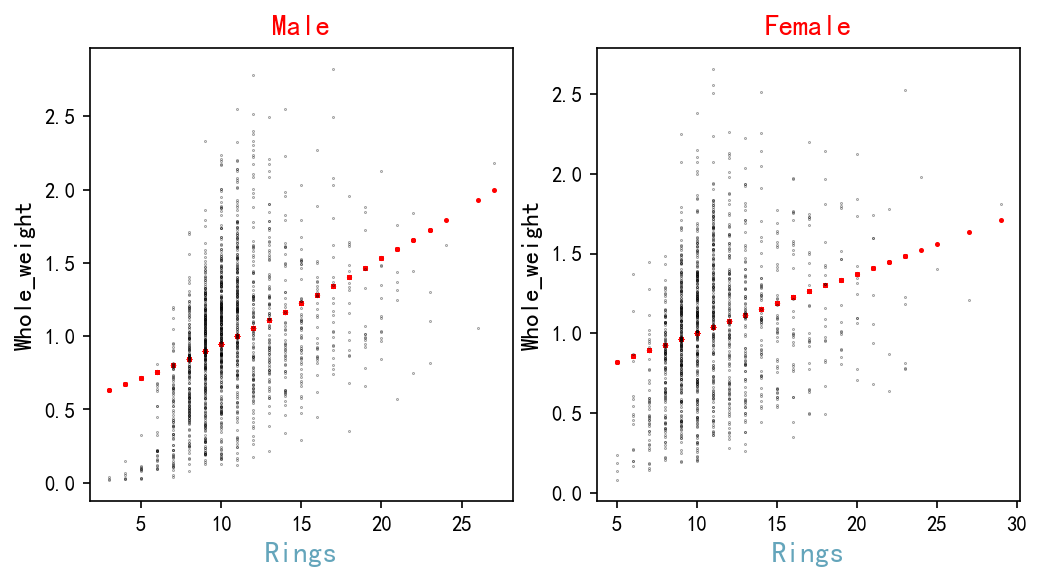

In [15]:
yfitted_Male = result3_Male.fittedvalues
yfitted_Female = result3_Female.fittedvalues
fig, axes = plt.subplots(1,2,figsize=(8, 4), dpi=150)
axes[0].scatter(data_3_Male["Rings"],yfitted_Male,c = "red",s = 2,alpha = 1)
axes[0].scatter(data_3_Male["Rings"],data_3_Male["Whole_weight"],c = "black" , s = 0.05 , alpha = 0.7)
axes[0].set_title("Male",fontsize = 14 , color = "red")
axes[0].set_xlabel("Rings",fontsize = 14,color = "#64a5bb")
axes[0].set_ylabel("Whole_weight",fontsize = 12)
axes[1].scatter(data_3_Female["Rings"],yfitted_Female,c = "red",s = 2,alpha = 1)
axes[1].scatter(data_3_Female["Rings"],data_3_Female["Whole_weight"],c = "black" , s = 0.05 , alpha = 0.7)
axes[1].set_title("Female",fontsize = 14 , color = "red")
axes[1].set_xlabel("Rings",fontsize = 14,color = "#64a5bb")
axes[1].set_ylabel("Whole_weight",fontsize = 12)
plt.savefig('images/test3.png')
plt.show()